# ECE 5424 Notebook Display

## Authored by Jason Cusati
## Base Code by John Smutny

In [1]:
'''
File:   main.py
Author: John Smutny
Course: ECE-5424: Advanced Machine Learning
Date:   11/19/2022
Description:
    Run data analysis of NBA Positions to visually and metrically determine
    if the NBA is becoming more position-homogenious over time, by decade.

    If desired, this program will also generate the csv file necessary to run
    the modeling if it is necessary.

    Original dataset provided by Omri Goldstein.
    https://www.kaggle.com/datasets/drgilermo/nba-players-stats?select=Seasons_Stats.csv

Input:
    1) Season_Stats.csv - Dataset from Basketball-Reference.com's
    'Total' and 'Advanced' data.
    2) Players.csv - Dataset from Kaggle (same location as INPUT 1)) that
    contains the heights and weights of all players in INPUT 1.

Output:
    Various. See each model .py file.
'''


import dataPreparation as dp
import hierarchyClustering as hc
from som import som
import pandas as pd
import paper.src.lib.modelCommon as common
from sklearn.decomposition import PCA


In [2]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import collections

In [3]:
def modifyDataForModel(df: pd.DataFrame,
                       INCLUDE_POS_FLAG, THREE_POS_FLAG) -> pd.DataFrame:

    # Remove Features
    REMOVE_FEATURES = ['ID', 'Player', 'Tm', 'Pos']

    # Also delete position features if they should not be used in modeling.
    if ~INCLUDE_POS_FLAG:
        if THREE_POS_FLAG:
            REMOVE_FEATURES.extend(["Pos_G", "Pos_F", "Pos_C"])
        else:
            REMOVE_FEATURES.extend(["Pos_PG", 'Pos_SG',
                                    "Pos_SF", "Pos_PF",
                                    "Pos_C"])

    df = df.drop(columns=REMOVE_FEATURES)

    return df

In [4]:
def runKmeans(df: pd.DataFrame, YEARS: list, INCLUDE_POS, THREE_POS_FLAG) -> bool:

    print(df.head())
    mod_data = modifyDataForModel(df, INCLUDE_POS, THREE_POS_FLAG)
    print(mod_data.head())
    scaler = StandardScaler()
    X = scaler.fit_transform(mod_data)
    num_clusters = len(df['Pos'].unique())
    print(pd.DataFrame(X).head())
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y = kmeans.fit_predict(X)
    print(X[:,0])
    print("Inertia")
    print(kmeans.inertia_)
    labels = kmeans.predict(X)
    print ("Clusters (result of k-means)")
    print (collections.Counter(pred_y))
    print ("Ground truth")
    print (collections.Counter(df['Pos']))
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Pos'], X[:,1])
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
    plt.show()

    df['Cluster'] = pred_y

    common.calcPositionConc(df, "Hierarchy", YEARS, THREE_POS_FLAG)

    return common.reportClusterScores(df, YEARS, INCLUDE_POS)


In [34]:
def runPCA(df: pd.DataFrame, YEARS: list, INCLUDE_POS, THREE_POS_FLAG) -> bool:

    print(df.head())
    mod_data = modifyDataForModel(df, INCLUDE_POS, THREE_POS_FLAG)
    print(mod_data.head())
    scaler = StandardScaler()
    X = scaler.fit_transform(mod_data)
    num_clusters = len(df['Pos'].unique())
    print(pd.DataFrame(X).head())

    pca = PCA(n_components=num_clusters)
    pca.fit(X)
    X_transform = pca.transform(X)

    print(
        "explained variance ratio: %s"
        % str(pca.explained_variance_ratio_)
    )

    plt.figure()
    colors = ["navy", "turquoise", "darkorange", "darkgreen", "maroon"]
    lw = 2

    y = df['Pos']
    target_names = df['Pos'].unique()

    for color, i, target_name in zip(colors, ['C', 'SF', 'PG', 'SG', 'PF'], target_names):
        plt.scatter(
            X_transform[y == i, 0], X_transform[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
        )
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.title("PCA of NBA dataset")
    plt.show()
    print("Transform: %s:"
        % str(X_transform))
    print(
        "Components: %s"
        % pca.components_)

    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y = kmeans.fit_predict(X_transform)

    df['Cluster'] = pred_y

    common.calcPositionConc(df, "Hierarchy", YEARS, THREE_POS_FLAG)

    return common.reportClusterScores(df, YEARS, INCLUDE_POS)


     ID    Year                Player  height  weight   Age Pos   Tm     G  \
0  3069  1971.0       Zaid Abdul-Aziz   206.0   106.0  24.0   C  SEA  61.0   
1  3070  1971.0  Kareem Abdul-Jabbar*   218.0   102.0  23.0   C  MIL  82.0   
2  3071  1971.0             Don Adams   198.0    95.0  23.0  SF  SDR  82.0   
3  3072  1971.0          Rick Adelman   185.0    79.0  24.0  PG  POR  81.0   
4  3073  1971.0          Lucius Allen   188.0    79.0  23.0  PG  MIL  61.0   

     GS  ...   STL   BLK   TOV     PF     PTS  Pos_C  Pos_PF  Pos_PG  Pos_SF  \
0  13.0  ...  34.0  12.5  63.0  118.0   665.0      1       0       0       0   
1  13.0  ...  34.0  12.5  63.0  264.0  2596.0      1       0       0       0   
2  13.0  ...  34.0  12.5  63.0  344.0   937.0      0       0       0       1   
3  13.0  ...  34.0  12.5  63.0  214.0  1023.0      0       0       1       0   
4  13.0  ...  34.0  12.5  63.0  108.0   433.0      0       0       1       0   

   Pos_SG  
0       0  
1       0  
2       0  
3 

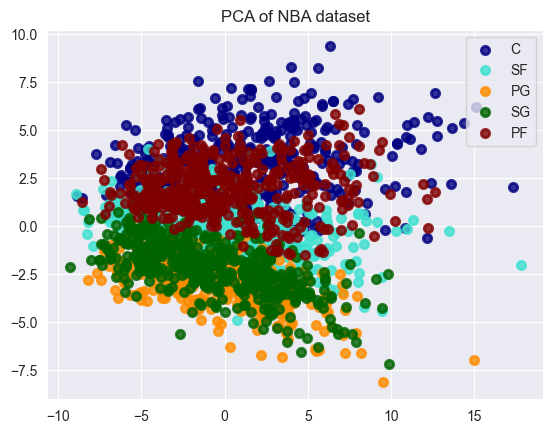

Transform: [[-1.73542456  1.4715896  -0.0735469  -2.18451341  0.44829974]
 [10.85370815 -0.10696314 -1.95649255 -6.57948915 -1.11610763]
 [-0.56641934 -0.1685417   2.76623672 -1.24702712  0.27372636]
 ...
 [-0.56319513  2.83974688 -1.62962343  0.87380866 -1.96957921]
 [ 2.7763169  -4.62097605 -0.89251376  1.53380626  7.30730168]
 [-1.87687607 -3.11073543 -1.65716085  2.05266577 -1.24849055]]:
Components: [[ 0.0312895   0.04685235  0.03845388  0.02655049  0.14837596  0.02017198
   0.21341484  0.19580959  0.15720167 -0.02111406  0.03678568  0.03502044
   0.06376925  0.05128699  0.04233873  0.01369688  0.05494236 -0.0261532
   0.0700555   0.20386631  0.18629643  0.22736176  0.18053766  0.17131464
   0.07644261  0.17617385  0.17323256  0.22025163  0.20989238  0.15048348
   0.01578489  0.01758655 -0.00696734  0.22021828  0.20979539  0.14996862
   0.15039956  0.21072612  0.21221515  0.05722414  0.15648038  0.16797202
   0.17900324  0.15138387  0.14661809  0.12574858  0.11696087  0.17910551
 

C:\Users\djjay\AppData\Local\Temp\ipykernel_30152\3461986098.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1048.395
SilhouetteCoefficient_Score = 0.126
Davies-Bouldin Index = 2.739
** Model3 (PCA): COMPLETE

        ID    Year                Player  height  weight   Age Pos   Tm     G  \
2194  6085  1981.0  Kareem Abdul-Jabbar*   218.0   102.0  33.0   C  LAL  80.0   
2195  6086  1981.0         Tom Abernethy   201.0    99.0  26.0  SF  TOT  78.0   
2196  6089  1981.0           Alvan Adams   206.0    95.0  26.0   C  PHO  75.0   
2197  6090  1981.0        Darrell Allums   206.0    99.0  22.0  PF  DAL  22.0   
2198  6091  1981.0       Tiny Archibald*   185.0    68.0  32.0  PG  BOS  80.0   

        GS  ...    STL    BLK    TOV     PF     PTS  Pos_C  Pos_PF  Pos_PG  \
2194  13.0  ...   59.0  228.0  249.0  244.0  2095.0      1       0       0   
2195  82.0  ...   14.0    6.0   16.0   68.0   126.0      0       0       0   
2196  13.0  ...  106.0   69.0  226.0  226.0  1115.0      1       0       0   
2197  13.0  ...    5.0   

<Figure size 640x480 with 0 Axes>

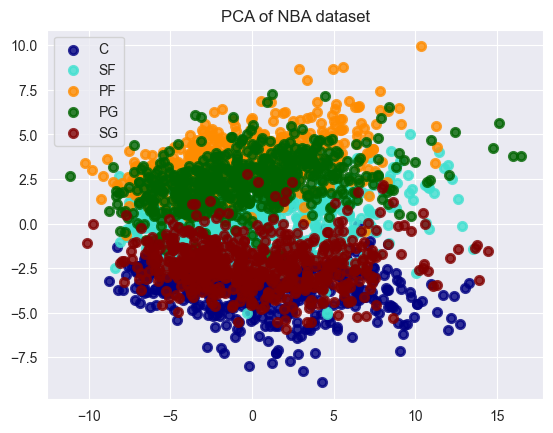

Transform: [[10.96432869 -3.3660784  -1.46744159 -0.89944006 -0.24964479]
 [-5.38324736 -1.18367041  0.79009475  0.25110755 -0.28765812]
 [ 5.15733553 -1.38996922 -1.16707186  2.52322533 -1.20901393]
 ...
 [ 7.10967798  0.83836889 -1.76362726 -0.74594795  1.00048737]
 [-2.53329484  3.13340222 -0.66572714  2.60223136  1.03809652]
 [-3.49778402  0.36043872 -2.89382862 -1.07182364  1.88627194]]:
Components: [[-2.78401927e-03  3.07285519e-02  3.07270281e-02  1.61828000e-02
   1.43872444e-01  1.69266898e-01  2.05812902e-01  1.94294174e-01
   1.48931122e-01 -1.95414857e-02  3.96472585e-02  3.17722763e-02
   5.19894633e-02  4.81788710e-02  3.12255205e-02  7.65021467e-03
   3.14475361e-02 -7.11823872e-02  1.02411157e-01  1.90514442e-01
   1.80407661e-01  2.13509700e-01  1.77108761e-01  1.84301334e-01
   5.95359754e-02  1.85752461e-01  1.82069437e-01  2.09047197e-01
   2.01359079e-01  1.35510408e-01  4.82154606e-02  5.54616055e-02
   5.22728562e-03  2.08721070e-01  2.01696138e-01  1.36077267e-0

C:\Users\djjay\AppData\Local\Temp\ipykernel_30152\3461986098.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1596.743
SilhouetteCoefficient_Score = 0.096
Davies-Bouldin Index = 1.571
** Model3 (PCA): COMPLETE

         ID    Year              Player  height  weight   Age Pos   Tm     G  \
5024  10007  1991.0      Alaa Abdelnaby   208.0   108.0  22.0  PF  POR  43.0   
5025  10008  1991.0  Mahmoud Abdul-Rauf   188.0    83.0  21.0  PG  DEN  67.0   
5026  10009  1991.0          Mark Acres   211.0    99.0  28.0   C  ORL  68.0   
5027  10010  1991.0       Michael Adams   178.0    73.0  28.0  PG  DEN  66.0   
5028  10011  1991.0        Mark Aguirre   198.0   105.0  31.0  SF  DET  78.0   

        GS  ...    STL   BLK    TOV     PF     PTS  Pos_C  Pos_PF  Pos_PG  \
5024   0.0  ...    4.0  12.0   22.0   39.0   135.0      0       1       0   
5025  19.0  ...   55.0   4.0  110.0  149.0   942.0      0       0       1   
5026   0.0  ...   25.0  25.0   42.0  218.0   285.0      1       0       0   
5027  66.0  ...  147.0   6.0  240.0

<Figure size 640x480 with 0 Axes>

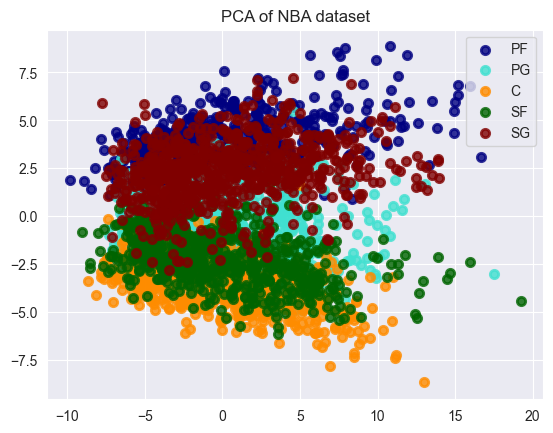

Transform: [[-4.51206467  3.19395211  0.94863398 -1.42392193 -0.6518925 ]
 [-1.92302902 -3.73390954 -3.57120098 -3.21039944 -2.41655398]
 [-1.82781268  3.52935382  1.51832173 -0.58819676 -0.10962594]
 ...
 [-5.13833251 -3.981017   -1.27772808  2.02805492  1.61402965]
 [ 1.18404774 -2.06983823 -1.89533115  1.92610587  0.30775247]
 [-1.43756969  2.01102077  0.77183279 -0.89508866 -0.41917885]]:
Components: [[-0.02247741  0.01385686  0.0128949   0.00486696  0.14603316  0.18511528
   0.20982173  0.18450241  0.12575392 -0.00989323  0.0332125   0.01144365
   0.04429041  0.03405263  0.05078079  0.02705449  0.01874041 -0.06097388
   0.10544824  0.19184747  0.18898591  0.21307227  0.15621576  0.16739042
   0.07134071  0.17857603  0.18300591  0.21502825  0.20814578  0.10809663
   0.08713536  0.09087679  0.00938186  0.21024793  0.20543878  0.1102136
   0.11209424  0.20561368  0.20771804  0.04956994  0.15418547  0.18482154
   0.17916222  0.14046106  0.17615865  0.11887449  0.19747196  0.1696786
  

C:\Users\djjay\AppData\Local\Temp\ipykernel_30152\3461986098.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1712.157
SilhouetteCoefficient_Score = 0.075
Davies-Bouldin Index = 1.975
** Model3 (PCA): COMPLETE

         ID    Year               Player  height  weight   Age Pos   Tm     G  \
8462  14967  2001.0   Mahmoud Abdul-Rauf   188.0    83.0  31.0  PG  VAN  41.0   
8463  14968  2001.0    Tariq Abdul-Wahad   198.0   101.0  26.0  SG  DEN  29.0   
8464  14969  2001.0  Shareef Abdur-Rahim   206.0   102.0  24.0  SF  VAN  81.0   
8465  14970  2001.0       Cory Alexander   185.0    83.0  27.0  PG  ORL  26.0   
8466  14971  2001.0   Courtney Alexander   185.0    83.0  23.0  PG  TOT  82.0   

        GS  ...   STL   BLK    TOV     PF     PTS  Pos_C  Pos_PF  Pos_PG  \
8462   0.0  ...   9.0   1.0   26.0   50.0   266.0      0       0       1   
8463  12.0  ...  14.0  13.0   34.0   54.0   111.0      0       0       0   
8464  81.0  ...  90.0  77.0  231.0  238.0  1663.0      0       0       0   
8465   0.0  ...  16.0   0.0   25.

<Figure size 640x480 with 0 Axes>

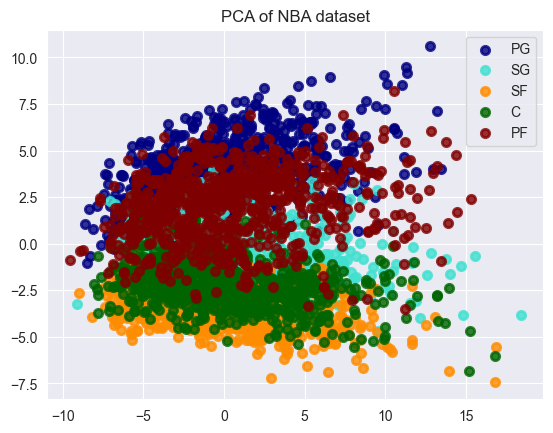

Transform: [[-3.62723512 -3.30960931 -2.23748458 -0.8628804  -2.93505981]
 [-6.3877681  -0.30132539  2.04493468  0.77998665 -0.59376548]
 [ 7.81383116  1.6051117   1.85150092 -0.21473322 -1.77038732]
 ...
 [-2.15093227 -2.7676653  -0.49260864 -3.27999141  0.08790028]
 [-1.83116526 -0.08327982  0.10465103 -1.76145872 -1.50603008]
 [ 0.78975868 -0.36976773  0.12398484 -1.51728842 -0.35501729]]:
Components: [[ 4.37443740e-03  1.08449502e-02  9.34501210e-03 -2.30682663e-03
   1.45716755e-01  1.82618238e-01  2.08141122e-01  1.86555312e-01
   1.24206422e-01 -2.37036015e-04  3.32851423e-02 -7.58945218e-03
   4.13441065e-02  2.31468240e-02  7.06205876e-02  2.80474890e-02
   1.06505376e-02 -6.33378530e-02  1.20863083e-01  1.94440205e-01
   1.79873431e-01  2.13745905e-01  1.56482838e-01  1.73599133e-01
   5.68008543e-02  1.80225657e-01  1.79960829e-01  2.15575056e-01
   2.08824519e-01  9.09768477e-02  1.11628921e-01  1.14337614e-01
   2.42326322e-02  2.09907506e-01  2.06041616e-01  9.46220696e-0

C:\Users\djjay\AppData\Local\Temp\ipykernel_30152\3461986098.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1978.494
SilhouetteCoefficient_Score = 0.089
Davies-Bouldin Index = 1.73
** Model3 (PCA): COMPLETE

          ID    Year             Player  height  weight   Age Pos   Tm     G  \
12218  20502  2011.0      Arron Afflalo   196.0    95.0  25.0  SG  DEN  69.0   
12219  20504  2011.0      Alexis Ajinca   218.0   112.0  22.0   C  TOT  68.0   
12220  20509  2011.0  LaMarcus Aldridge   211.0   117.0  25.0  PF  POR  81.0   
12221  20511  2011.0          Ray Allen   203.0    99.0  35.0  SG  BOS  80.0   
12222  20512  2011.0         Tony Allen   193.0    96.0  29.0  SG  MEM  72.0   

         GS  ...    STL   BLK    TOV     PF     PTS  Pos_C  Pos_PF  Pos_PG  \
12218  69.0  ...   34.0  31.0   71.0  153.0   867.0      0       0       0   
12219   4.0  ...   22.0  38.0   36.0  146.0   286.0      1       0       0   
12220  81.0  ...   82.0  94.0  153.0  220.0  1769.0      0       1       0   
12221  80.0  ...   77.0  16.0  1

<Figure size 640x480 with 0 Axes>

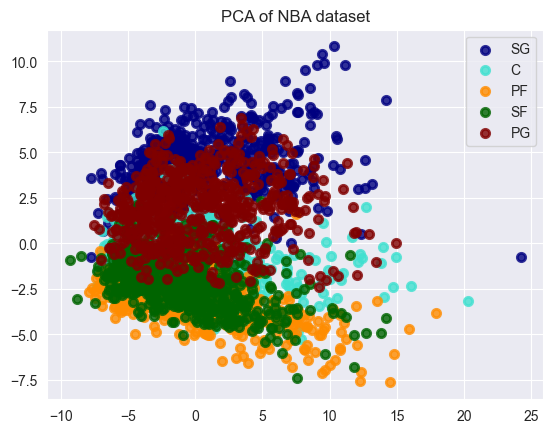

Transform: [[ 2.2150475  -1.2911495  -3.23636697  1.61530843  0.09390368]
 [-3.07851752  2.07491608  0.76578459  1.11415857 -0.40658328]
 [ 9.63206251  2.61417474  1.75600452  0.21801397 -2.39471392]
 ...
 [-3.66755823  3.60331653 -0.27363599  0.07799206 -1.02878703]
 [-4.55062209 -0.4515555   0.26891426  1.32725452  0.15648285]
 [-2.66304269  4.19702595 -0.80450107  0.11587765 -1.94648361]]:
Components: [[ 7.70289673e-03  1.85941821e-02  2.96617362e-02  1.48680038e-03
   1.45430517e-01  1.80250099e-01  2.03469980e-01  1.81334414e-01
   1.15325266e-01 -3.71680712e-02  5.85767379e-02  2.42819144e-02
   5.89616831e-02  4.89816201e-02  6.63265942e-02  2.60123567e-02
   2.61061760e-02 -3.93071625e-02  1.20712492e-01  1.93440480e-01
   1.91110777e-01  2.15570678e-01  1.53677646e-01  1.61350487e-01
   5.99478509e-02  1.72255758e-01  1.78321597e-01  2.17209683e-01
   2.06801894e-01  9.40369918e-02  1.06948864e-01  1.08131391e-01
   7.33259774e-03  2.12172796e-01  2.06769627e-01  8.59132083e-0

C:\Users\djjay\AppData\Local\Temp\ipykernel_30152\3461986098.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


** Model Hierarchy Position Extraction: COMPLETE
Calinski_Harabasz_Score = 1603.307
SilhouetteCoefficient_Score = 0.108
Davies-Bouldin Index = 1.903
** Model3 (PCA): COMPLETE



<Figure size 640x480 with 0 Axes>

In [35]:
'''
Program Control flags and constants fr operation.
 Please customize these values to produce the outputs desired.

-- Flags --
DEBUG   - Simple program run. Run only one decade of information. Most
            commonly used for debugging purposes.
LOAD_MODEL_DATA - Determine if the program should create the data used in
                    modeling (see the program's two inputs) or load an already
                    created .csv file from a previous run when this flag was
                    set to FALSE.
                    (REQUIRES two input .csv files - see file header)
OUTPUT_FILES_FLAG - Decide if reference DataQualityReports and other csvs for
                     independent validation should be created.
INCLUDE_POS - Flag to specify if models should consider a player's
                Position (PG, SF, C, etc) in modeling.
THREE_POSITION_FLAG - Specify how many positions to consider. The traditional
                        five positions {PG, SG, SF, PF, C} or condensed
                        summarized positions {G, F, C}

-- File Paths --
PLAYER_PATH - File path to a dataset with player height and weight
DATA_PATH - File path to a dataset with player statistics

-- Numerics and Lists --
YEARS   - List of numeric Pairs stating what year range for a model to consider.
DQR_NON_NUMERIC_COLUMNS - List from DATA_PATH of features that are not Numeric.
                            (Used by the DataQualityReport class)
REQ_GAMES - Numeric. Filter to remove players that don't play enough games
              in a season.
REG_MIN - Numeric. Filter to remove players that don't play enough
               'minutes per game' in a season.
'''
DEBUG = False
LOAD_MODEL_DATA = True

PLAYER_PATH = "../data/input/Players.csv"
#DATA_PATH = "../data/input/Seasons_Sta ts.csv" #1950-2017
DATA_PATH = "../data/input/Seasons_Stats_1950_2022.csv"  #1950-2022
OUTPUT_FILES_FLAG = False

HIERARCHICAL = False
SOM = False
KMEANS = False
PCAModel = True

REQ_GAMES = 20
REQ_MIN = 10
INCLUDE_POS = True
THREE_POSITION_FLAG = False

DQR_NON_NUMERIC_COLUMNS = ['Unnamed: 0', 'Player', 'Tm', 'Pos',
                           'blanl', 'blank2']

YEARS = [[1971, 1980],
         [1981, 1990],
         [1991, 2000],
         [2001, 2010],
         [2011, 2020]]

if DEBUG:
    YEARS = [YEARS[0], YEARS[1]]


##########################
################
##########################

'''
** Program Execution starts HERE **
'''
# Load your own correctly formatted csv file to reduce computation time.
if LOAD_MODEL_DATA:
    df_data = pd.read_csv("../data/ref/Season_Stats_MODEL_{}-{}.csv".format(
                            YEARS[0][0], YEARS[len(YEARS)-1][1]))
else:
    df_data = dp.initialDataModification(PLAYER_PATH, DATA_PATH, YEARS,
                                          REQ_GAMES, REQ_MIN,
                                          THREE_POSITION_FLAG,
                                          DQR_NON_NUMERIC_COLUMNS,
                                          OUTPUT_FILES_FLAG)

# Create Cluster Metric dataframe placeholder to collect all metrics
df_metrics_hierarchy = pd.DataFrame(columns=['Years', 'CHS', 'SC', 'DBI'])
df_metrics_som = pd.DataFrame(columns=['Years', 'CHS', 'SC', 'DBI'])

for YEAR in YEARS:
    df_year = df_data[(df_data['Year'] >= YEAR[0])
                         & (df_data['Year'] <= YEAR[1])]

    if HIERARCHICAL:
        metrics = hc.hierarchicalClustering(df_year, [YEAR[0], YEAR[1]],
                                            INCLUDE_POS, THREE_POSITION_FLAG)
        df_metrics_hierarchy.loc[len(df_metrics_hierarchy)] = metrics
        print("** Model1 (Divisive Clustering): COMPLETE\n")

    if SOM:
        metrics = som(df_year, [YEAR[0], YEAR[1]],
                      INCLUDE_POS, THREE_POSITION_FLAG)
        df_metrics_som.loc[len(df_metrics_som)] = metrics
        print("** Model2 (SOM Clustering): COMPLETE\n")

    if KMEANS:
        metrics = runKmeans(df_year, [YEAR[0], YEAR[1]],
                      INCLUDE_POS, THREE_POSITION_FLAG)
        #df_metrics_som.loc[len(df_metrics_som)] = metrics
        print("** Model3 (SOM KMeans): COMPLETE\n")

    if PCAModel:
        metrics = runPCA(df_year, [YEAR[0], YEAR[1]],
                      INCLUDE_POS, THREE_POSITION_FLAG)
        df_metrics_som.loc[len(df_metrics_som)] = metrics
        print("** Model3 (PCA): COMPLETE\n")


df_metrics_hierarchy.to_csv(
    '../data/output/MODEL_Metrics_Hierarchy_{}-{}.csv'.format(
        YEARS[0][0], YEARS[len(YEARS)-1][1]),
    index=False)

df_metrics_som.to_csv(
    '../data/output/MODEL_Metrics_som_{}-{}.csv'.format(
        YEARS[0][0], YEARS[len(YEARS)-1][1]),
    index=False)



